In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
# from util import *

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Utils

In [3]:
def InFV(data): # cm
    xmin = -199.15 + 10
    ymin = -200. + 10
    zmin = 0.0 + 10
    xmax = 199.15 - 10
    ymax =  200. - 10
    zmax =  500. - 50
    return (data.x > xmin) & (data.x < xmax) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

def InBeam(t):
    return (t > 0.) & (t < 1.800)

In [4]:
def is_cosmic(df):
    return (df.slc.truth.pdg == -1)

def is_FV(df): 
    return (InFV(df.position))

def is_numu(df):
    return (np.abs(df.pdg) == 14)

def is_CC(df):
    return (df.iscc == 1)

def is_NC(df):
    return (df.iscc == 0)

def is_1p0pi(df):
    return (df.nmu_20MeV == 1) & (df.np_50MeV == 1) & (df.npi_40MeV == 0) & (df.npi0 == 0)

def is_signal(df):
    return is_numu(df) & is_CC(df) & is_1p0pi(df) & is_FV(df)

def is_outFV(df):
    return is_numu(df) & is_CC(df) & is_1p0pi(df) & np.invert(is_FV(df))

def is_othernumuCC(df):
    return is_numu(df) & is_CC(df) & np.invert(is_1p0pi(df)) & is_FV(df)

# Plotters

In [5]:
mode_list = [0, 10, 1, 2, 3]
mode_labels = ['QE', 'MEC', 'RES', 'SIS/DIS', 'COH', "other"]
mode_colors = ["darkorchid", "royalblue", "forestgreen", "darkorange", "firebrick"]

def breakdown_mode(var, df):
    ret = [var[df.genie_mode == i] for i in mode_list] 
    return ret


In [6]:
top_labels = ["Signal",
              "Other numu CC",
              "NC",
              "Out of FV",
              "Cosmic",
              "Other"]

top_colors = []
def breakdown_top(var, df):
    ret = [var[is_signal(df)],
           var[is_othernumuCC(df)],
           var[is_NC(df)],
           var[is_outFV(df)],
           var[is_cosmic(df)],
           var[np.invert(is_signal(df) | is_othernumuCC(df) | is_NC(df) | is_outFV(df) | is_cosmic(df))]
           ]
    return ret

# Selection

In [7]:
df = pd.read_hdf("/exp/sbnd/data/users/munjung/osc/sbnd.df", "evt")
# df = pd.read_hdf("/home/munjung/osc/sync/sbnana/sbnana/SBNAna/osc-villiage/test.df", "evt")

## FV cut

In [8]:
df = df[InFV(df.slc.vertex)]

## Cosmic Rejection

In [9]:
# Traditional 
nu_score = (df.slc.nu_score > 0.5)
# f_match = (df.slc.fmatch.score < 7.0) & (InBeam(df.slc.fmatch.time))
cosmic_rejection = nu_score #& f_match

# CRUMBS
# crumbs = (df.slc_crumbs_result.score > 0)
# cosmic_rejection = (crumbs)

df = df[cosmic_rejection]

signal purity 31.09 %


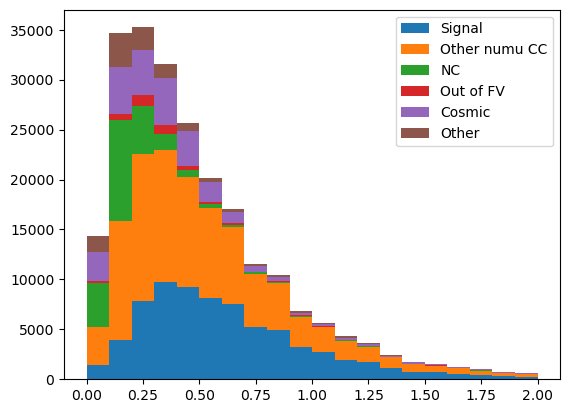

In [10]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();

## Select 1mu1p topology

In [11]:
# reject slices with any showers or 3rd tracks
twoprong_cut = (np.isnan(df.other_shw_length) & np.isnan(df.other_trk_length))

df = df[twoprong_cut]

signal purity 47.47 %


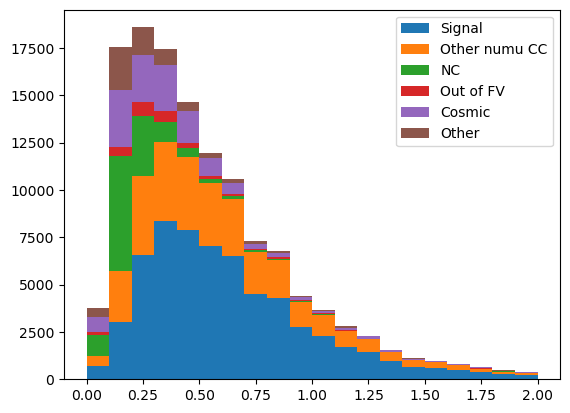

In [12]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();

In [13]:
# muon cut on muon candidates
MUSEL_MUSCORE_TH = 25
MUSEL_PSCORE_TH = 100
MUSEL_LEN_TH = 50

# TODO: use scores of all 3 planes
# muon_chi2 = (Avg(df, "muon", drop_0=True) < MUSEL_MUSCORE_TH) & (Avg(df, "proton", drop_0=True) > MUSEL_PSCORE_TH)

# TODO: used BDT scores
# len_cut = (masterdf.len.squeeze() > MUSEL_LEN_TH)
# dazzle_muon = (masterdf.dazzle.muonScore > 0.6)
# muon_cut = (muon_chi2) & (len_cut | dazzle_muon)

mu_score_cut = (df.mu.pfp.trk.chi2pid.I2.chi2_muon < MUSEL_MUSCORE_TH) & (df.pfp.trk.chi2pid.I2.chi2_proton > MUSEL_PSCORE_TH)
mu_len_cut = (df.mu.pfp.trk.len > MUSEL_LEN_TH)
mu_cut = (mu_score_cut) & (mu_len_cut)

# proton cut on proton candidates
PSEL_MUSCORE_TH = 0
PSEL_PSCORE_TH = 90

p_score_cut = (df.p.pfp.trk.chi2pid.I2.chi2_muon > PSEL_MUSCORE_TH) & (df.p.pfp.trk.chi2pid.I2.chi2_proton < PSEL_PSCORE_TH) 
p_cut = p_score_cut

# select slices with mu+p
slc_mu_cut = mu_cut.groupby(level=[0,1,2]).any()
slc_p_cut = p_cut.groupby(level=[0,1,2]).any()
df = df.loc[slc_mu_cut & slc_p_cut]

signal purity 86.13 %


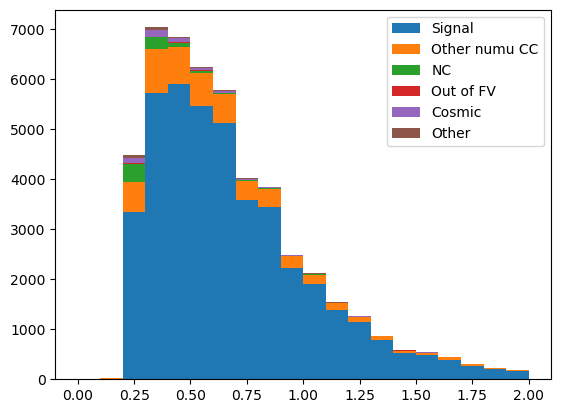

In [14]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();

## Stubs cut

In [15]:
l_cuts = [5.5e5, 4e5, 3e5, 0]
cut_list = []
for i,l in enumerate(["0_5", "1", "2", "3"]):
    this_cut = np.invert((df.stub["l"+l+"cm"].Q/df.stub["l"+l+"cm"].length) > l_cuts[i])
    cut_list.append(this_cut)
    df = df.loc[this_cut]

signal purity 89.17 %


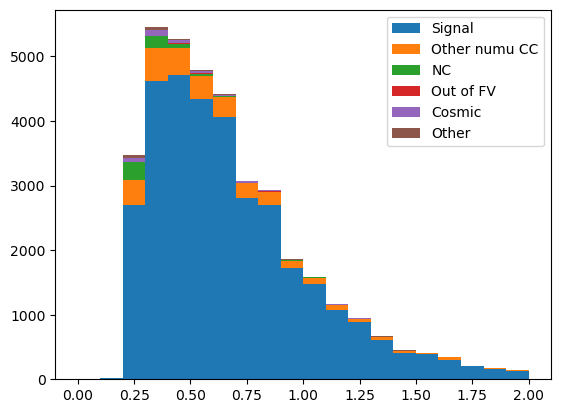

In [16]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();

## Transverse momentum imbalance cut

In [17]:
DELP_TH = 0.25

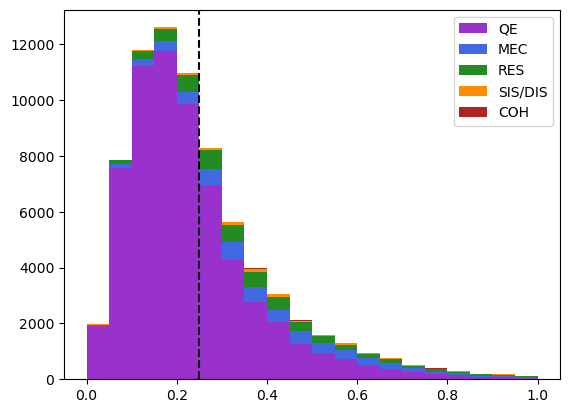

In [18]:
var = breakdown_mode(df.del_p, df)
n, bins, _ = plt.hist(var, bins=np.linspace(0,1,21), stacked=True, 
                      label=mode_labels, color=mode_colors)
plt.axvline(DELP_TH, color='k', linestyle="--")
plt.legend()
plt.show();

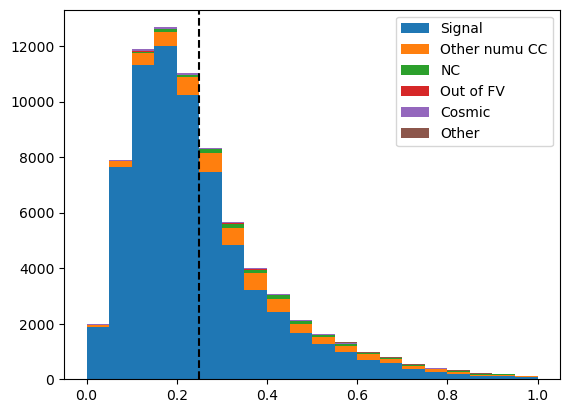

In [19]:
var = df.del_p
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,1,21), stacked=True, 
                      label=top_labels)
plt.axvline(DELP_TH, color='k', linestyle="--")
plt.legend()
plt.show();

In [20]:
# transverse momentum cut
delp_cut = (df.del_p < DELP_TH)

df = df[delp_cut]

signal purity 94.69 %


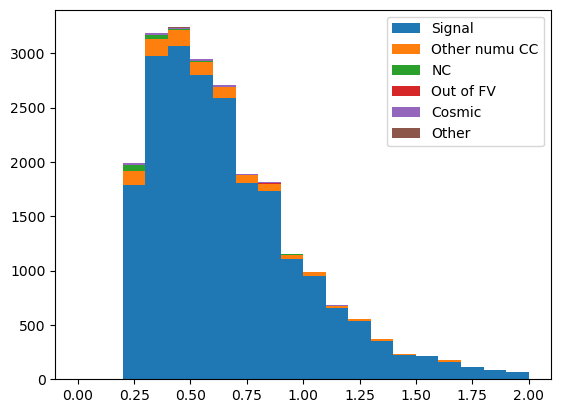

In [21]:
var = df.mu.pfp.trk.P.p_muon
pvar = breakdown_top(var, df)
n, bins, _ = plt.hist(pvar, bins=np.linspace(0,2,21), stacked=True, 
                      label=top_labels)
print("signal purity {:.2f} %".format(100*n[0].sum()/n[-1].sum()))
plt.legend()
plt.show();